# CoverMyMeds Challenge

In this challenge we are presented with a set of simulated pharmacy claims data-billing claims that were run from a pharmacy to a third-party payer who covers some portion of the prescription drug price on behalf of a patient. Most commonly these third-party payers are the patient insurance plans, but other third parties such as manufacturer discount drug programs can also be run in the same manner as insurance claims to reimburse the pharmacy some portion of the cost. 

Ultimately, as part of the claim process the amount that the payer reimburses the pharmacy and copayments required of the patient are set by complicated negotiations and contracts between the drug manufacturer, the payer, and the pharmacy. Those negotiations also often cover decisions on what drug claims will ultimately be approved (preferred / non-preferred / non-covered formulary status of each drug) based on the relative discounts that the payer can secure relative to other drugs in the same class that may treat similar types of medical conditions.

For this challenge, we build a method of predicting the copayments required of patients ahead of time using this claim billing data. The ultimate goal of this model is to provide doctors information about the costs that their patient would expect to see in the pharmacy in case affordability of the medication is an issue. We also provide information about the potential formulary status of the medication on each insurance plan, and develop a method of grouping similar medications together so that all the options under a patient’s insurance can be compared together based on their relative formulary statuses and copayment requirements.

## 1. Exploratory Data Analysis

First, we import some standard packages, read in the data, and have a look.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime

In [2]:
df = pd.read_csv('pharmacy_tx.csv', parse_dates=[0])

There are about 13.9 million insurance claims spanning 2022 in the data provided, which contain:

- 'tx_date': The date on which the pharmacy transaction was attempted
- 'pharmacy': The particular pharmacy where the transaction was attempted
- 'diagnosis': The diagnosis of the patient associated with the transaction
- 'drug': The drug that the patient was prescribed that the pharmacy is attempting to bill
- 'bin': The broadest identifier of a patient’s insurance plan (banking identification number)
- 'pcn': An identifier that more narrowly specifies a plan underneath the broader “bin”
- 'group': Another identifier that more narrowly specifies a plan underneath the broader “bin”
- 'rejected': Whether the billing transaction was rejected by the plan
- 'patient_pay': The amount of copayment for which the patient is responsible

Here's a sample.

In [3]:
df.sample(5)

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay
7811109,2022-08-04,Pharmacy #53,W50.87,branded glycontazepelol,664344,TPJD,NaN,False,19.82
10616456,2022-10-11,Pharmacy #53,I68.27,generic prazinib,96934,9D24,VC81HUO7ZD,False,10.72
523847,2022-01-17,Pharmacy #16,W50.87,generic glycontazepelol,322463,3O71UTS,NaN,False,6.34
3132484,2022-04-01,Pharmacy #16,I68.27,branded hidizuzunib,725700,327CKV,IOEAN1DWVV3Y,False,95.52
7699821,2022-08-01,Pharmacy #22,I68.27,branded prazinib,756120,7THOQ5,NaN,False,16.42


There are missing values among the 'pcn' and 'group' columns. However, that is most likely due to the nature of the third-party payers rather than some random input error. For example, a 'group' is connected to a patient's employer, so self-employed patients who shop for insurance in the marketplace will not be able to provide such a number on a claim.

Most claims in the supplied data are accepted and associated with a handful of BINs. Although claims increase over the year, the patient pay is generally higher at the beginning of the year. This is most likely due to the deductible cycle renewing at the start of the year.

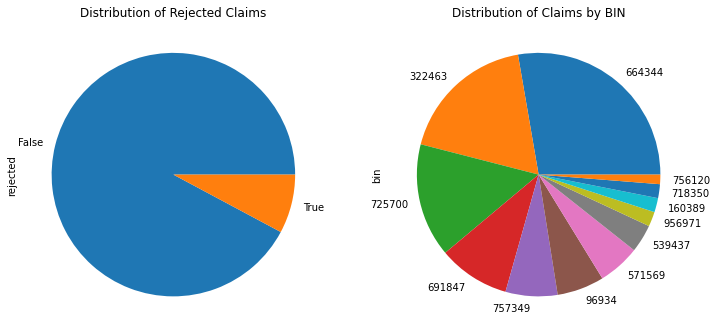

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
df.rejected.value_counts(normalize=True).plot(kind='pie')
plt.title('Distribution of Rejected Claims')

plt.subplot(1, 2, 2)
df['bin'].value_counts(normalize=True).plot(kind='pie')
plt.title('Distribution of Claims by BIN')

plt.show()

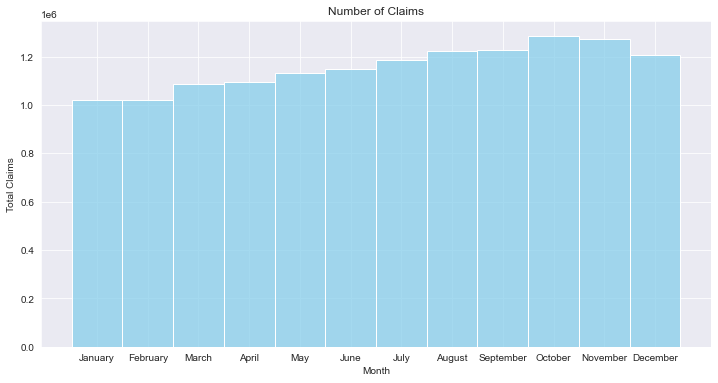

In [5]:
#Sort the data by month
df['month'] = df['tx_date'].dt.month_name()

#Plot the claims by month
sns.set_style("darkgrid")
plt.figure(figsize=(12,6))
ax = sns.histplot(x='month', data=df, color='skyblue')
ax.set(xlabel='Month', ylabel='Total Claims')
plt.title('Number of Claims')

plt.show()

#Get rid of unnecessary column introduced
df = df.drop(columns=['month']);

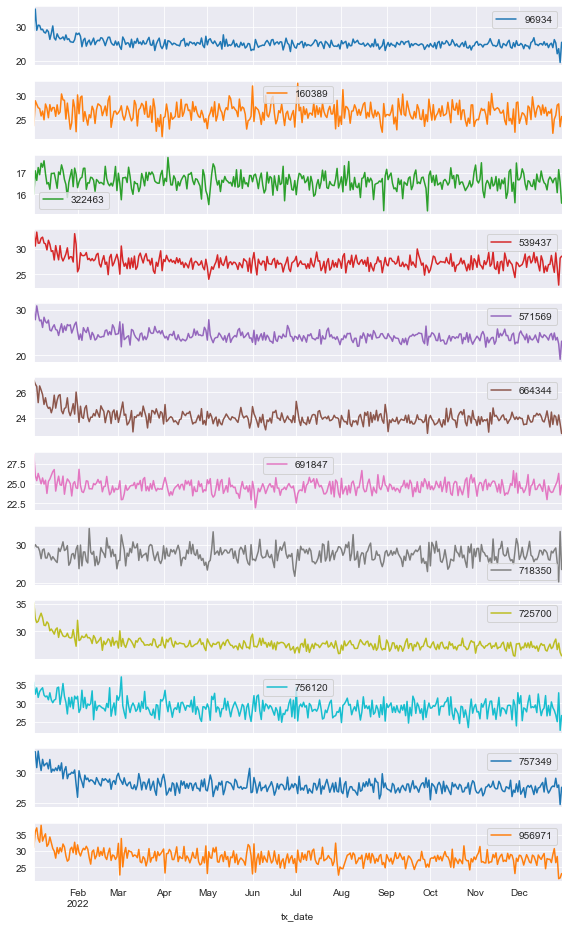

In [6]:
df.pivot_table(index='tx_date', columns='bin', values='patient_pay'
              ).plot(subplots=True,figsize=(8,13))
plt.tight_layout()

## 2. Predicting Patient Pay

We now turn to the task of predicting the payment a patient will be responsible for when they purchase a particular drug under a given plan. We will focus only on accepted claims since there is no way of knowing whether a patient will pay the full price of the drug or look for an alternative in the case where a claim is rejected.

One seemingly limiting feature of the data is that no more than two payments ever occur when one narrows down on a drug, pharmacy, and group (or plan). However, we chose to ignore this artifact of the dataset and proceed with a model that would be useful even when there is more variety present in the out of pocket expenses observed.

In [7]:
df_clean=df[df['rejected'] == False]
df_agg = df_clean.groupby(['drug','pharmacy','group']).patient_pay.unique()
print(df_agg)

maxPatientPaysPerGroup= 0
for group in df_agg:
    maxPatientPaysPerGroup=max(maxPatientPaysPerGroup,len(group))

print("Max patient pays per group : ", maxPatientPaysPerGroup)

drug               pharmacy     group       
branded antimab    Pharmacy #0  0OGKQ           [42.85, 16.87]
                                1CAHL            [42.85, 23.8]
                                52H8KH0F83K             [6.11]
                                6BYJBW          [23.26, 12.13]
                                6SP1DG                 [16.59]
                                                     ...      
generic vocopirin  Pharmacy #9  T51T6V2E8L              [18.0]
                                YY6B1J4E8KJ3     [17.58, 9.35]
                                Z01MLD4I        [12.99, 17.58]
                                ZOYKF0N5NEO            [17.15]
                                ZX2QUWR         [17.58, 12.99]
Name: patient_pay, Length: 181801, dtype: object
Max patient pays per group :  2


Although many models were considered, we'll describe the random forest model here, which offers a nice balance of speed and predictive power. First, we import the necessary packages and perform the test/train split.

In [8]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from regressors import stats

In [9]:
train,test= train_test_split(df_clean,test_size=0.2)

In [10]:
train_temp=train
test_temp=test

To deal with the large number of categorical features present in the data, some feature engineering is performed. Here we introduce features p1, ..., p8 by aggregating over various columns. 

In [11]:
#Feature p1
temp = train_temp.groupby(['drug','pharmacy','bin'],as_index=False).patient_pay.mean()
temp['p1'] = temp['patient_pay']
del temp['patient_pay']

train_temp = pd.merge(train_temp,temp,on=['drug','pharmacy','bin'], how='left')
test_temp = pd.merge(test_temp,temp,on=['drug','pharmacy','bin'], how='left')

#Feature p2
temp = train_temp.groupby(['drug','pharmacy','group'],as_index=False).patient_pay.mean()
temp['p2'] = temp['patient_pay']
del temp['patient_pay']

train_temp = pd.merge(train_temp,temp,on=['drug','pharmacy','group'], how='left')
train_temp['p2']=train_temp['p2'].fillna(train_temp['p1'])
test_temp = pd.merge(test_temp,temp,on=['drug','pharmacy','group'], how='left')

#Feature p3
temp = train_temp.groupby(['drug','pharmacy','diagnosis'],as_index=False).patient_pay.mean()
temp['p3'] = temp['patient_pay']
del temp['patient_pay']

train_temp = pd.merge(train_temp,temp,on=['drug','pharmacy','diagnosis'], how='left')
test_temp = pd.merge(test_temp,temp,on=['drug','pharmacy','diagnosis'], how='left')

#Feature p4
temp = train_temp.groupby(['drug','pharmacy'],as_index=False).patient_pay.mean()
temp['p4'] = temp['patient_pay']
del temp['patient_pay']

train_temp = pd.merge(train_temp,temp,on=['drug','pharmacy'], how='left')
test_temp = pd.merge(test_temp,temp,on=['drug','pharmacy'], how='left')

#Feature p5
temp = train_temp.groupby(['drug','pharmacy','pcn'],as_index=False).patient_pay.mean()
temp['p5'] = temp['patient_pay']
del temp['patient_pay']

train_temp = pd.merge(train_temp,temp,on=['drug','pharmacy','pcn'], how='left')
train_temp['p5']=train_temp['p5'].fillna(train_temp['p1'])
test_temp = pd.merge(test_temp,temp,on=['drug','pharmacy','pcn'], how='left')

#Feature p6
temp = train_temp.groupby(['drug','diagnosis'],as_index=False).patient_pay.mean()
temp['p6'] = temp['patient_pay']
del temp['patient_pay']

train_temp = pd.merge(train_temp,temp,on=['drug','diagnosis'], how='left')
test_temp = pd.merge(test_temp,temp,on=['drug','diagnosis'], how='left')

#Feature p7
temp = train_temp.groupby(['drug','pcn'],as_index=False).patient_pay.median()
temp['p7'] = temp['patient_pay']
del temp['patient_pay']

train_temp = pd.merge(train_temp,temp,on=['drug','pcn'], how='left')
test_temp = pd.merge(test_temp,temp,on=['drug','pcn'], how='left')

#Feature p8
temp = train_temp.groupby(['drug','group'],as_index=False).patient_pay.median()
temp['p8'] = temp['patient_pay']
del temp['patient_pay']

train_temp = pd.merge(train_temp,temp,on=['drug','group'], how='left')
test_temp = pd.merge(test_temp,temp,on=['drug','group'], how='left')

Now that we have the features we would like to use, we prepare the data for the model. Since we are using a random forest model, we can remove the duplicates and reduce the time it takes to train the model considerably. 

In [12]:
train_temp['p7']=train_temp['p7'].fillna(train_temp['p1'])
train_temp['p8']=train_temp['p7'].fillna(train_temp['p1'])

train_temp2=train_temp[['p1','p2','p3','p4','p5','p6','p7','p8']]
train_temp2=train_temp2.drop_duplicates()

In [13]:
train_temp2=train_temp[['p1','p2','p3','p4','p5','p6','p7','p8','patient_pay']]
train_temp2=train_temp2.drop_duplicates()

X_train=train_temp2[['p1','p2','p3','p4','p5','p6','p7','p8']]
y_train=train_temp2['patient_pay']

# imputing the test data with other non-null entries
test_temp['p1']=test_temp['p1'].fillna(test_temp['p6'])
test_temp['p2']=test_temp['p2'].fillna(test_temp['p1'])
test_temp['p3']=test_temp['p3'].fillna(test_temp['p1'])
test_temp['p5']=test_temp['p5'].fillna(test_temp['p1'])
test_temp['p7']=test_temp['p7'].fillna(test_temp['p1'])
test_temp['p8']=test_temp['p7'].fillna(test_temp['p1'])


X_test=test_temp[['p1','p2','p3','p4','p5','p6','p7','p8']]
y_test=test_temp['patient_pay']

The model is fitted and the performance scores are given below. Although we are happy with the overall results, we also point out some cases where the model performs poorly. 

In [14]:
rf = RandomForestRegressor(max_depth=10,max_features=5,verbose=1,n_jobs=2)

rf.fit(X_train,y_train)

pred_train = rf.predict(X_train)

print(r2_score(pred_train, y_train))
print(mean_absolute_error(pred_train, y_train))
print(mean_squared_error(pred_train, y_train))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   24.7s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   53.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.7s


0.9876190602790798
2.84829468093981
38.722349366432645


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.6s finished


In [15]:
# predictions
pred = rf.predict(X_test)

print(r2_score(pred,y_test))
print(mean_absolute_error(pred,y_test))
print(mean_squared_error(pred,y_test))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.6s


0.9924331382341781
1.5290450558840154
13.099747561014707


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    7.9s finished


In [16]:
test_temp['pred']=pred

# entries where our predictions are off by $50

test_temp[(abs(test_temp.patient_pay - test_temp.pred)>50)]

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,p1,p2,p3,p4,p5,p6,p7,p8,pred
1241,2022-01-13,Pharmacy #46,D13.25,branded plazamiglutic,664344,BIZF,QK6BI1N61,False,120.17,57.212302,64.153200,66.215801,65.440944,64.153200,63.411050,63.73,63.73,68.761194
2375,2022-03-15,Pharmacy #10,B45.03,branded masonic,757349,MSCXSG,DGLGRYP,False,313.63,242.538571,242.538571,193.940686,193.940686,242.538571,203.553935,237.34,237.34,252.449433
23004,2022-02-01,Pharmacy #42,Z25.06,branded genetramycicin,322463,YICC41,MP3IQ,False,219.30,56.888182,56.888182,131.071104,135.496694,56.888182,134.602537,180.25,180.25,89.424768
55666,2022-01-25,Pharmacy #49,L85.13,branded flacelfatastat,757349,MSCXSG,DGLGRYP,False,303.10,231.390000,231.390000,214.500508,215.693111,231.390000,202.874451,230.04,230.04,242.024593
68724,2022-01-11,Pharmacy #51,Q72.66,branded tugesutin,664344,CS8580,NaN,False,243.77,143.847927,143.847927,144.044510,149.875743,185.780000,161.937314,185.34,185.34,188.073898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2493433,2022-10-07,Pharmacy #41,X75.30,branded nephelilin,96934,9D24,VC81HUO7ZD,False,19.74,110.525385,110.525385,81.436853,85.294362,110.525385,87.652632,19.74,19.74,72.608287
2494882,2022-03-16,Pharmacy #2,U06.52,branded tugesutin,664344,CS8580,NaN,False,243.77,148.002213,148.002213,183.513590,154.586372,185.000000,158.240723,185.34,185.34,186.516041
2540740,2022-01-06,Pharmacy #26,Q72.66,branded tugesutin,664344,CS8580,NaN,False,243.77,163.486847,163.486847,164.624235,166.911698,184.580000,161.937314,185.34,185.34,187.161832
2552214,2022-01-12,Pharmacy #49,Z20.23,branded flacelfatastat,756120,7THOQ5,NaN,False,321.12,250.438519,250.438519,215.844430,215.693111,250.438519,205.396673,246.67,246.67,256.518600


In [17]:
rf.feature_importances_

array([1.33661764e-03, 5.43861092e-01, 2.03189917e-04, 4.54770106e-04,
       2.65971922e-01, 1.12664663e-03, 1.01821160e-01, 8.52246022e-02])

In [18]:
test_temp.sample(10)

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,p1,p2,p3,p4,p5,p6,p7,p8,pred
311141,2022-05-08,Pharmacy #48,K87.68,generic ribosatharin,664344,NaN,52H8KH0F83K,False,12.56,12.548034,12.560000,11.750184,11.768775,12.548034,11.682464,12.548034,12.548034,12.601701
166478,2022-07-13,Pharmacy #18,M42.24,branded hivir,664344,DY4B,NaN,False,17.11,16.386132,16.386132,16.288812,16.191060,17.110000,16.552421,17.110000,17.110000,17.143961
2520103,2022-05-03,Pharmacy #26,P07.55,generic colade,664344,IF448,FZPLF4O6FD,False,7.61,12.257920,7.610000,10.442246,10.412688,7.610000,9.845134,7.610000,7.610000,7.809198
222093,2022-09-23,Pharmacy #28,Q32.32,generic bovirol,757349,MSCXSG,DGLGRYP,False,9.83,9.234737,9.830000,10.960909,9.645240,9.830000,9.516868,9.830000,9.830000,9.850634
909275,2022-12-01,Pharmacy #21,I68.27,generic prazinib,956971,WM6A,L9QZA,False,8.43,8.880000,8.880000,10.744269,10.724435,8.880000,10.649487,6.980000,6.980000,9.085213
1911950,2022-11-29,Pharmacy #1,G99.93,branded pucomalol,571569,KB38N,6BYJBW,False,14.14,14.140000,14.140000,14.960568,14.917271,14.140000,15.054519,14.140000,14.140000,14.075491
2500556,2022-08-05,Pharmacy #32,G99.93,branded bovirol,322463,3O71UTS,NaN,False,12.22,12.070483,12.070483,12.971219,12.870365,12.220000,13.287239,12.220000,12.220000,12.500065
570963,2022-04-05,Pharmacy #17,I68.27,branded hidizuzunib,691847,XH4T3,GOM8K0,False,68.25,68.112266,68.250000,72.445674,73.068940,68.250000,70.488112,68.610000,68.610000,70.172502
2085864,2022-10-14,Pharmacy #16,Q85.91,branded cupitelol,539437,NaN,1CAHL,False,15.47,15.470000,15.470000,13.645694,13.552184,15.470000,13.655964,15.470000,15.470000,15.550017
2238458,2022-06-18,Pharmacy #33,Z95.40,branded tafistitrisin,322463,T52GV,EVD4X5,False,10.32,11.848212,10.320000,10.320000,13.894329,10.320000,13.743495,10.320000,10.320000,10.459899


## 3. Formularly Status (continue to formulary_status_summary.ipynb)